In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [4]:
import utils.pong
import utils.model
import utils.visualization
import utils.tensorflow

import tensorflow as tf
import numpy as np

import sacred

tf.__version__

'2.0.0'

In [5]:
ex = sacred.Experiment(name='RNN Experiment', interactive=True)

In [6]:
ex.observers.append(sacred.observers.MongoObserver())

In [7]:
@ex.config
def config():
    SEQ_LEN = 256
    W, H = 40, 40
    internal_size=32

In [8]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
):
    #### Data Generation
    stateful_pong_generator = utils.pong.StatefulPongGenerator(W, H, SEQ_LEN)

    def data_input():
        for (d, c), (f, g) in stateful_pong_generator:
            stateful_pong_generator.stochasticity = np.random.uniform(0, 1)
            yield (np.array([np.sin(d), np.cos(d)]), c), f

    make_dataset = lambda bs: tf.data.Dataset.from_generator(
        data_input,
        output_types=((tf.float32, tf.float32), tf.float32),
    ).take(8000).cache().repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

    #### Model
    model = utils.model.Model(internal_size=internal_size, W=W, H=H)
    model.net.summary()
    
    tf.keras.utils.plot_model(model.net, to_file='model.png', show_shapes=True, expand_nested=False, rankdir='LR', dpi=90)
    
    #### Callbacks
    callbacks = [
        utils.tensorflow.model_persistor(model),
        utils.tensorflow.on_batch_begin(
            lambda: utils.visualization.plot_pairwise_frames(
                sampler=lambda: list(make_dataset(1).take(1))[0],
                hypotheses=lambda x: model.net.predict(x)[0]
            )
        ),
        model.tb_callback
    ]
    
    #### Training
    input_generator = make_dataset(bs=128)
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=128,
        epochs=200,
        callbacks=callbacks
    )

INFO - RNN Experiment - Running command 'main'
INFO - RNN Experiment - Started run with ID "2"


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 32)           96          game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 32)     3456        user_input[0][0]                 
                                                                 project_activation[0][0]     

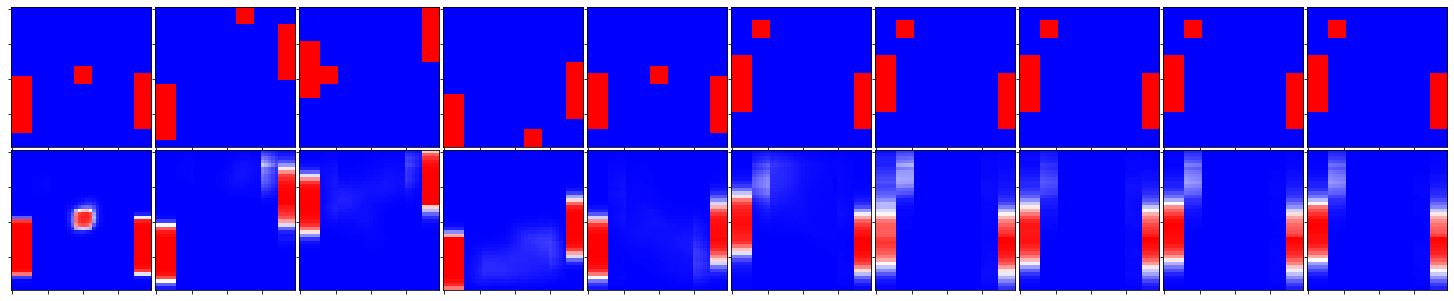

Epoch 1/200
128/128 [==============================] - 84s 659ms/step - loss: 0.0932 - mse: 0.0260 - val_loss: 0.0911 - val_mse: 0.0252


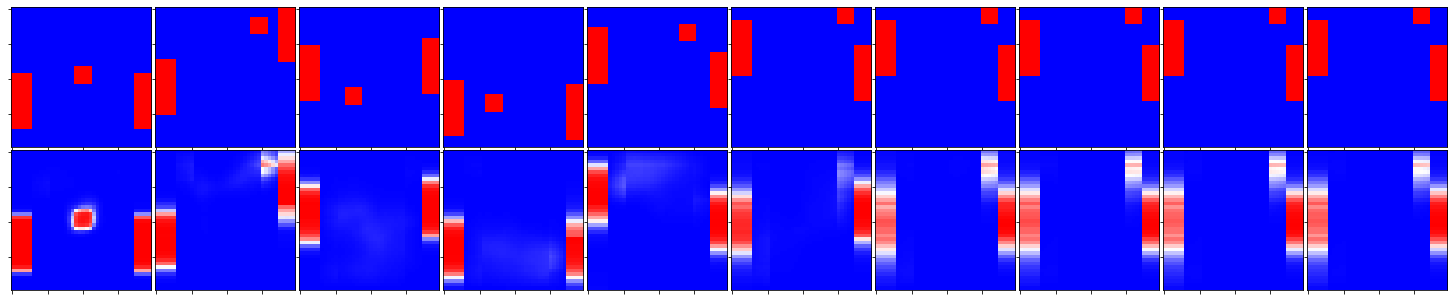

Epoch 2/200
128/128 [==============================] - 46s 360ms/step - loss: 0.0899 - mse: 0.0250 - val_loss: 0.0894 - val_mse: 0.0249


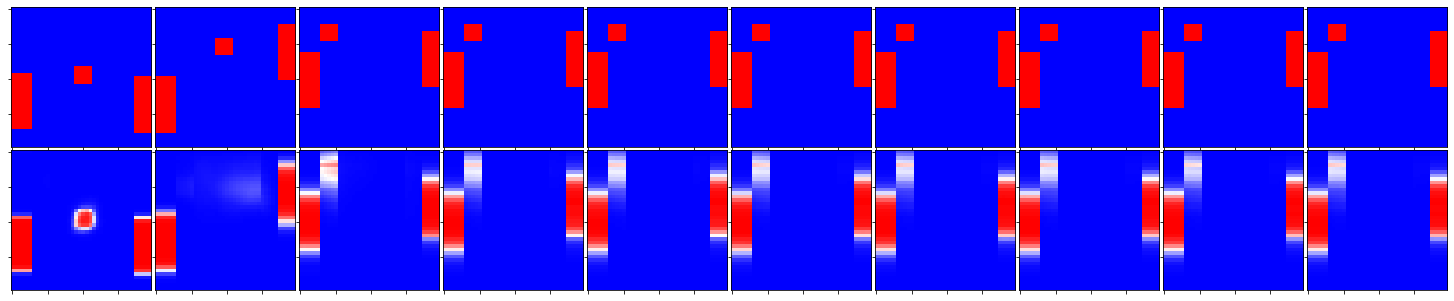

Epoch 3/200
128/128 [==============================] - 46s 358ms/step - loss: 0.0890 - mse: 0.0248 - val_loss: 0.0887 - val_mse: 0.0245


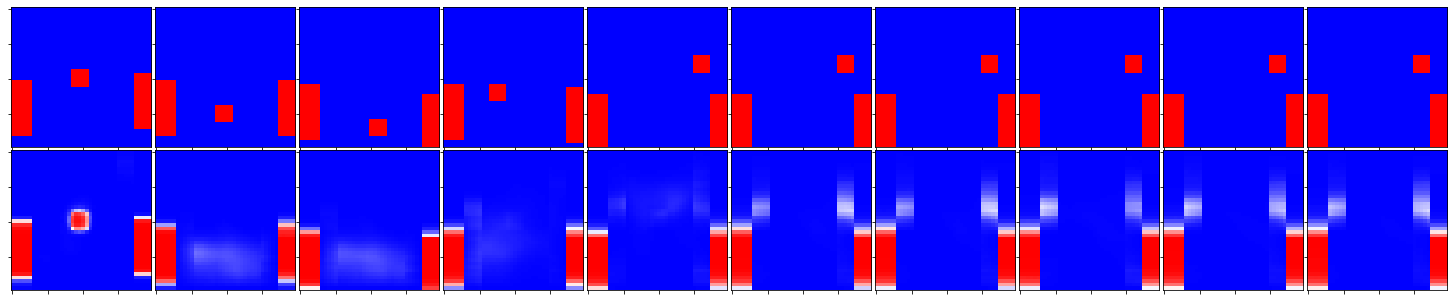

Epoch 4/200
128/128 [==============================] - 46s 358ms/step - loss: 0.0885 - mse: 0.0247 - val_loss: 0.0887 - val_mse: 0.0245


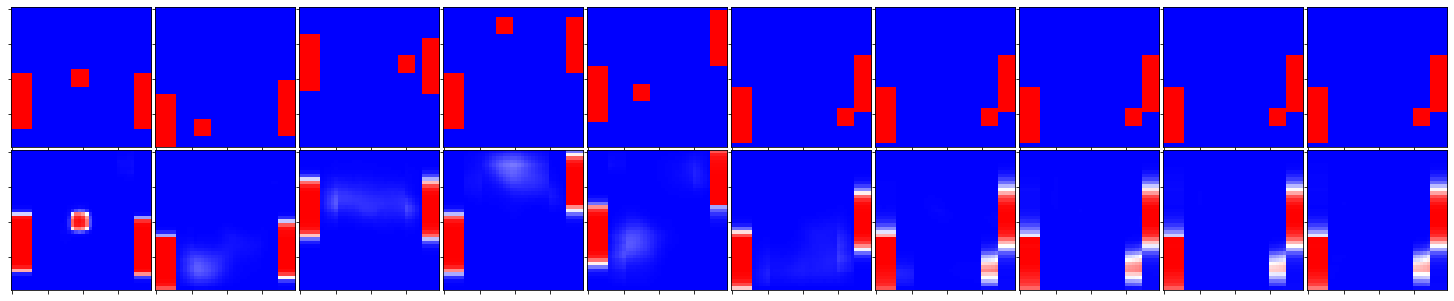

Epoch 5/200
128/128 [==============================] - 46s 355ms/step - loss: 0.0880 - mse: 0.0245 - val_loss: 0.0895 - val_mse: 0.0249


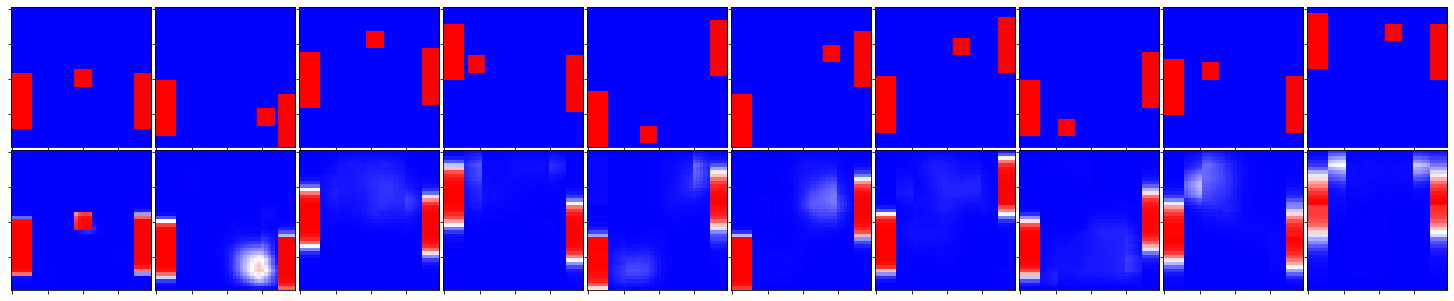

Epoch 6/200
128/128 [==============================] - 46s 357ms/step - loss: 0.0875 - mse: 0.0244 - val_loss: 0.0914 - val_mse: 0.0255


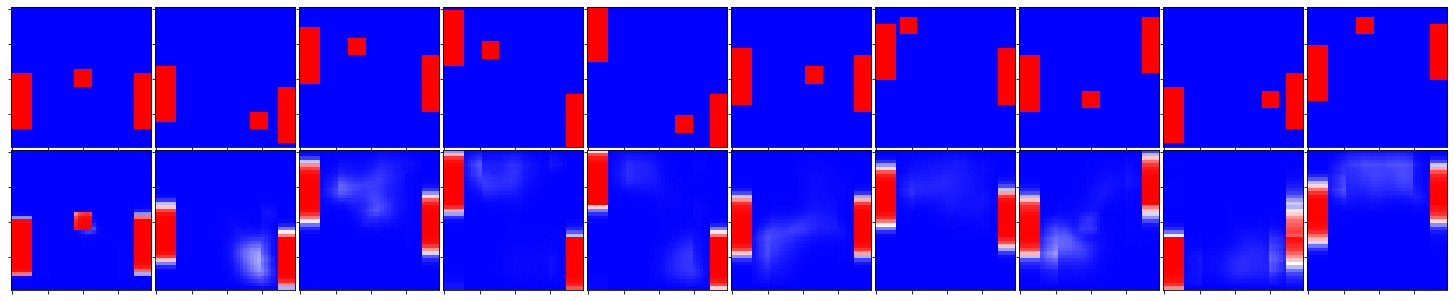

Epoch 7/200
128/128 [==============================] - 46s 359ms/step - loss: 0.0884 - mse: 0.0247 - val_loss: 0.0928 - val_mse: 0.0258


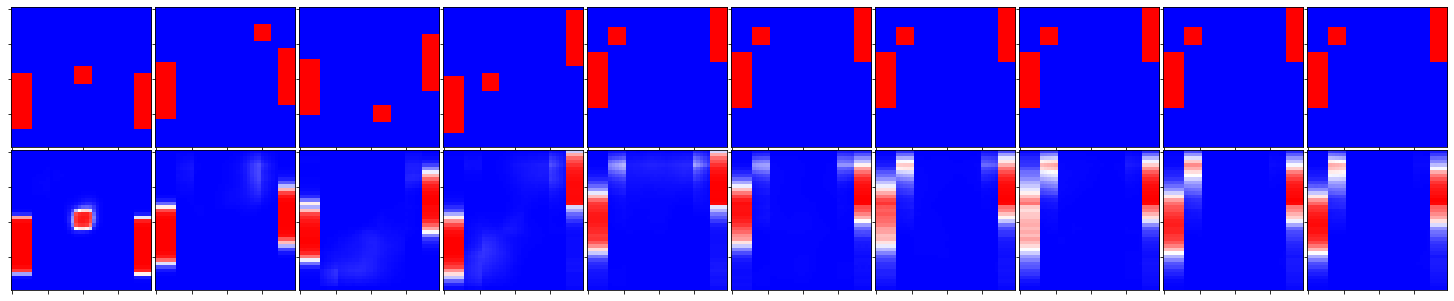

Epoch 8/200
128/128 [==============================] - 46s 359ms/step - loss: 0.0869 - mse: 0.0243 - val_loss: 0.0931 - val_mse: 0.0257


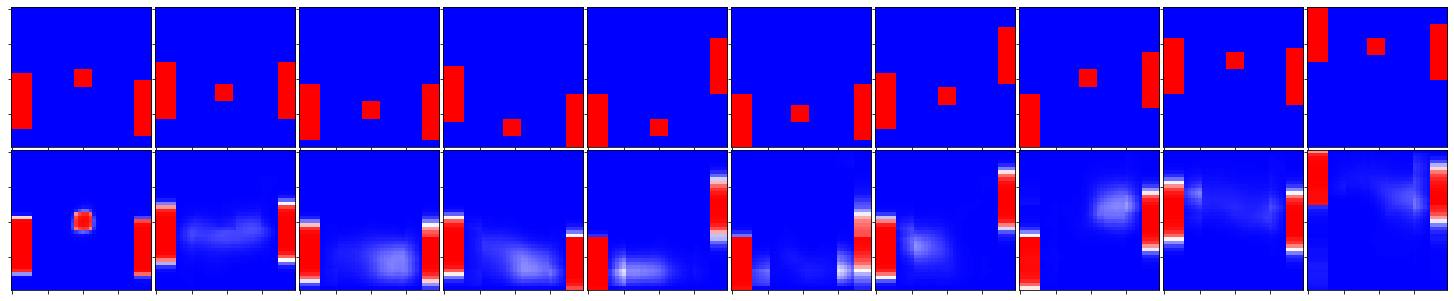

Epoch 9/200
128/128 [==============================] - 46s 358ms/step - loss: 0.0867 - mse: 0.0242 - val_loss: 0.0869 - val_mse: 0.0242


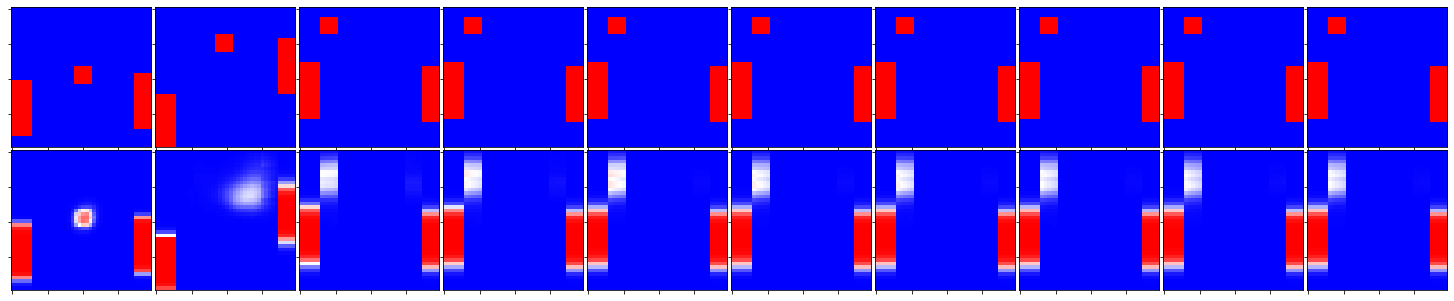

Epoch 10/200
128/128 [==============================] - 46s 362ms/step - loss: 0.0866 - mse: 0.0242 - val_loss: 0.0885 - val_mse: 0.0247


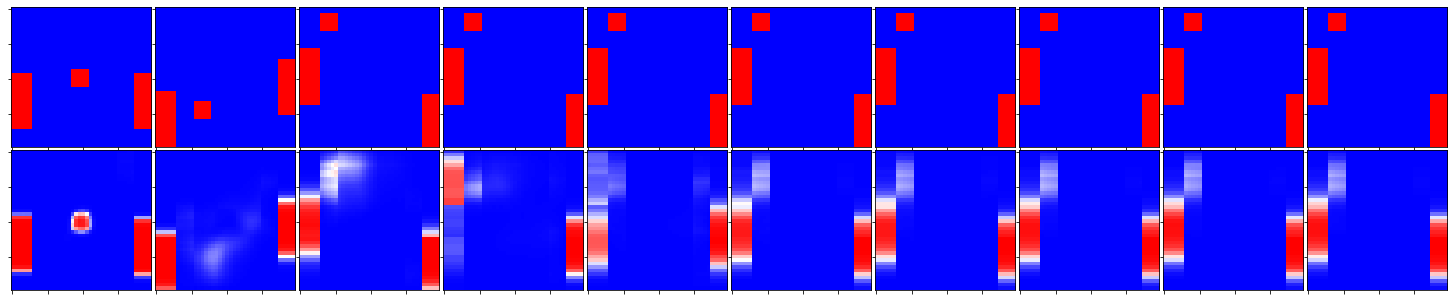

Epoch 11/200
128/128 [==============================] - 46s 357ms/step - loss: 0.0858 - mse: 0.0240 - val_loss: 0.0892 - val_mse: 0.0249


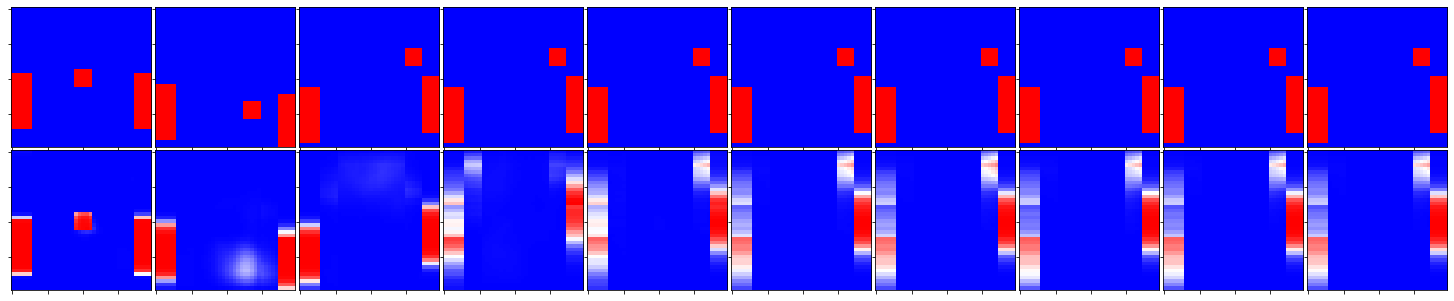

Epoch 12/200
 97/128 [=====================>........] - ETA: 11s - loss: 0.0860 - mse: 0.0240

In [ ]:
ex.run()